In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=55
b1=0.1

A=15
B=15
C=-48.78

b2=0.2
tau_H=10
DD=105
Tmin=14.5
gamma= 1/365 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

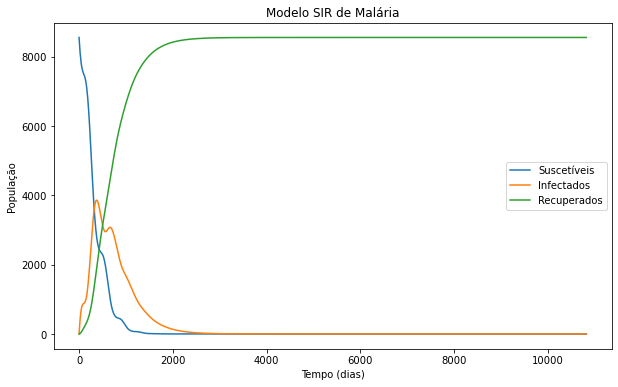

In [4]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

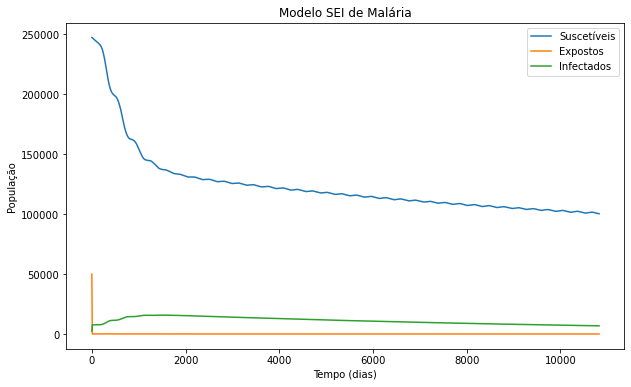

In [5]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

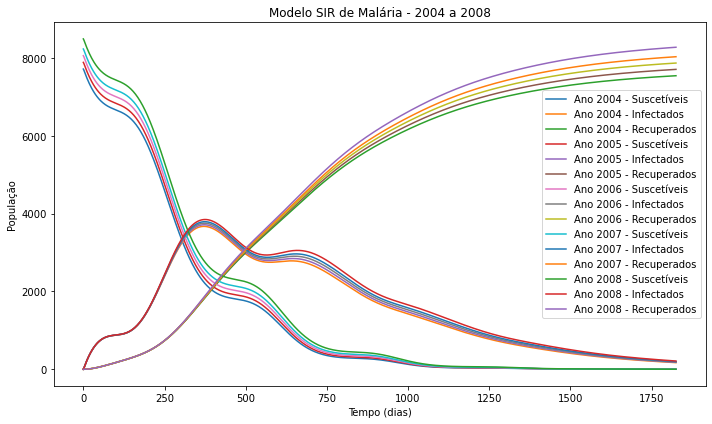

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_H, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, I_H, label=f'Ano {year} - Infectados')
    ax.plot(times, R_H, label=f'Ano {year} - Recuperados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SIR de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

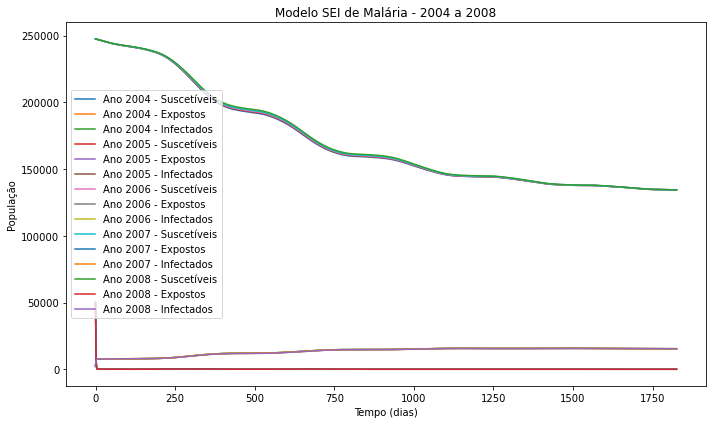

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_M, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, E_M, label=f'Ano {year} - Expostos')
    ax.plot(times, I_M, label=f'Ano {year} - Infectados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

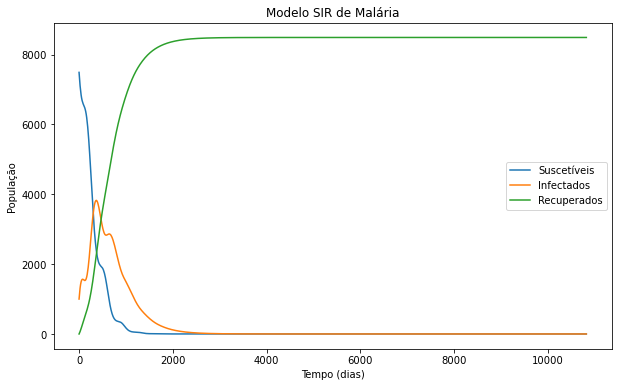

In [8]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

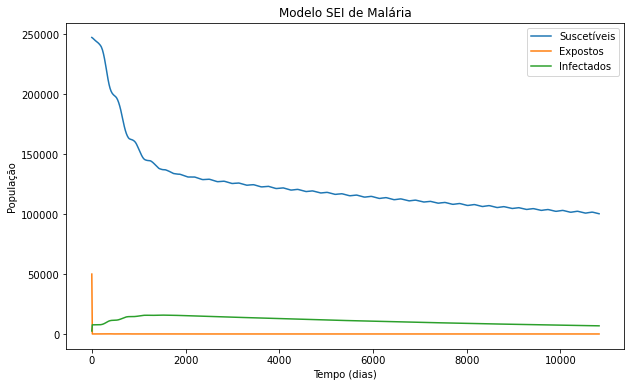

In [9]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

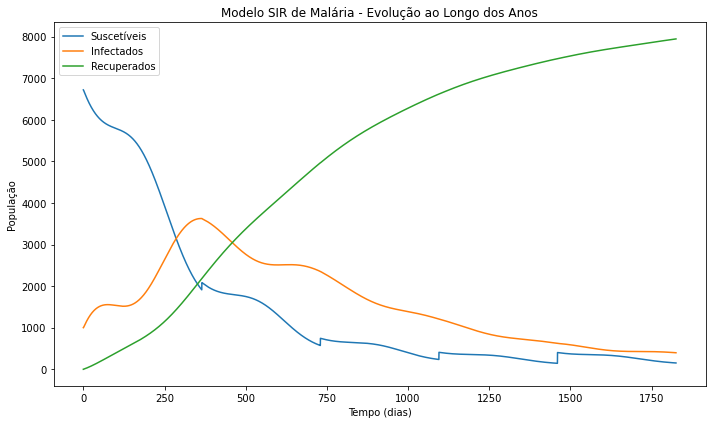

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

all_years_S_H = []
all_years_I_H = []
all_years_R_H = []

all_years_S_M = []
all_years_E_M = []
all_years_I_M = []

for year in range(2004, 2009):
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[year - 2004]
    
    if year == 2004:
        I_H0 = 1000
        R_H0 = 0
        
        E_M0 = 50000
        I_M0 = 2500
        
    else:
        I_H0 = all_years_I_H[-1][-1]
        R_H0 = all_years_R_H[-1][-1]
        
        #E_M0 = all_years_E_M[-1][-1]
        #I_M0 = all_years_I_M[-1][-1]
        
    if E_M0 is None:
        E_M0 = M / 100
        
        
    S_H0 = N - I_H0 - R_H0
    S_M0 = M - E_M0 - I_M0
    
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 365, 1000)
    sol = solve_ivp(model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    all_years_S_H.append(S_H)
    all_years_I_H.append(I_H)
    all_years_R_H.append(R_H)

all_years_S_H = np.concatenate(all_years_S_H, axis=0)    
all_years_I_H = np.concatenate(all_years_I_H, axis=0)
all_years_R_H = np.concatenate(all_years_R_H, axis=0)
time_total = np.linspace(0, 365 * 5, 1000 * 5)  # Tempo total de 5 anos

ax.plot(time_total, all_years_S_H, label='Suscetíveis')
ax.plot(time_total, all_years_I_H, label='Infectados')
ax.plot(time_total, all_years_R_H, label='Recuperados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SIR de Malária - Evolução ao Longo dos Anos')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Esse código reinicia S_M0 a cada ano ao invés de continuar a partir do valor final do ano anterior

# fig, ax = plt.subplots(figsize=(10, 6))

# all_years_S_M = []
# all_years_E_M = []
# all_years_I_M = []

# for year in range(2004, 2009):
#     pop_rural = [7717, 7889, 8061, 8233, 8492]
#     N = pop_rural[year - 2004]
    
#     if E_M0 is None:
#         E_M0 = M / 100
    
#     if year == 2004:
#         E_M0 = 50000
#         I_M0 = 2500

#     else:
# #         I_H0 = all_years_I_H[-1][-1]
# #         R_H0 = all_years_R_H[-1][-1]
        
#         E_M0 = all_years_E_M[-1][-1]
#         I_M0 = all_years_I_M[-1][-1]
    
#     S_M0 = M - E_M0 - I_M0
        
        
#         #S_H0 = N - I_H0 - R_H0
    
    
#     args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)
    
#     t_eval = np.linspace(0, 1825, 1000)
#     sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#     times = sol.t
#     S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
#     all_years_S_M.append(S_M)
#     all_years_E_M.append(E_M)
#     all_years_I_M.append(I_M)
#     print(all_years_S_M)
#     #print(all_years_I_M)
#     print(' ')

# all_years_S_M = np.concatenate(all_years_S_M, axis=0)    
# all_years_E_M = np.concatenate(all_years_E_M, axis=0)
# all_years_I_M = np.concatenate(all_years_I_M, axis=0)

# time_total = np.linspace(0, 1825, 1000 * 5)  # Tempo total de 5 anos

# ax.plot(time_total, all_years_S_M, label='Suscetíveis')
# ax.plot(time_total, all_years_E_M, label='Expostos')
# ax.plot(time_total, all_years_I_M, label='Infectados')

# ax.set_xlabel('Tempo (dias)')
# ax.set_ylabel('População')
# ax.set_title('Modelo SEI de Malária - Evolução ao Longo dos Anos')
# ax.legend()

# plt.tight_layout()
# plt.show()

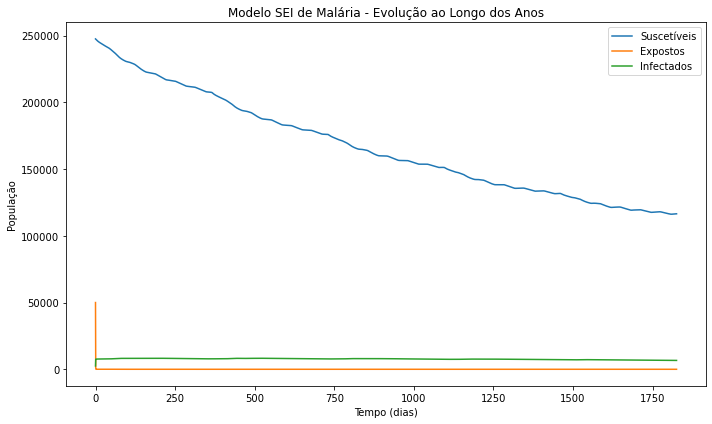

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

all_years_S_M = []
all_years_E_M = []
all_years_I_M = []

for year in range(2004, 2009):
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[year - 2004]
    
    if E_M0 is None:
        E_M0 = M / 100
    
    if year == 2004:
        E_M0 = 50000
        I_M0 = 2500
        S_M0 = M - E_M0 - I_M0

    else:
#         I_H0 = all_years_I_H[-1][-1]
#         R_H0 = all_years_R_H[-1][-1]
        
        E_M0 = all_years_E_M[-1][-1]
        I_M0 = all_years_I_M[-1][-1]
        S_M0 = all_years_S_M[-1][-1]
        
        
        #S_H0 = N - I_H0 - R_H0
    
    
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    all_years_S_M.append(S_M)
    all_years_E_M.append(E_M)
    all_years_I_M.append(I_M)

all_years_S_M = np.concatenate(all_years_S_M, axis=0)    
all_years_E_M = np.concatenate(all_years_E_M, axis=0)
all_years_I_M = np.concatenate(all_years_I_M, axis=0)

time_total = np.linspace(0, 1825, 1000 * 5)  # Tempo total de 5 anos

ax.plot(time_total, all_years_S_M, label='Suscetíveis')
ax.plot(time_total, all_years_E_M, label='Expostos')
ax.plot(time_total, all_years_I_M, label='Infectados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - Evolução ao Longo dos Anos')
ax.legend()

plt.tight_layout()
plt.show()